## CUSTOMER CHURN AT TELCO
**Or, Where did all the phone calls go ?**

### Goals :  
- To analyse factors leading to customer churn at Telco
- To create working models to allow for the prediction of future customer churn.

In [1]:
# IMPORTS

import os
import env

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from math import sqrt
from scipy import stats

# import our my acquire module
import acquire
import prepare


# import splitting, imputing and modelling functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from prepare import my_train_test_split, telco_training_validate_testing

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
import sklearn

# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

### DATA ACQUISITION

- Data was originally obtained from IBM, and came to us here via Codeup, in the form of a .csv file.
- The dataframe contained 7043 rows and 23 columns, with datatypes of integers, objects and floats.
- Each row represented a Telco customer.
- Each column represented aspects of Telco services or customer preferences.

### DATA PREPARATION

- To prepare the data, it was necessary to drop any unnecessary, unhelpful or duplicated columns, then encode the categorical columns and create dummy variables of the categorical columns.
- These dummy variables were then concatenated onto the imported Telco dataframe.
- Any null values, of which there appeared to be none, were dropped.
- It was decided to specifically explore the features of being a senior citizen, customer use of paperless billing, customer purchase of tech support and customer choice of internet service type (or no internet service at all).
    - Accordingly, these four categorical features were transformed into dummy variables, allowing for more fluid analysis.
- The data was then split into training, validation and testing sets (60/20/20), with the target variable of 'churn'.
- Outliers were not examined or removed.

### Data Dictionary :
**1. Tenure :** Customer time with Telco company in months.

**2. DF :** Dataframe, here referring to the Telco dataset.

**3. Target variable :** The aspect of the data against which all other aspects will be evaluated. Here, it's 'churn'.

**4. Churn :** Customer churn, a 1 / 0 (yes / no) representation of whether the customer has remained with the company.


### An Initial Look At Telco

In [2]:
# obtaining the prepared Telco dataset.

telco_df = acquire.get_telco_data(env.sql_connexion)
tidy_telco = prepare.prep_telco(telco_df)


In [3]:
tidy_telco.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,paperless_billing_No,paperless_billing_Yes,churn_No,churn_Yes
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,1,0,0,1,0,1,0,1,1,0
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,0,1,1,0,1,0,1,0,1,0
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,0,1,1,0,1,0,0,1,0,1
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,0,1,0,1,1,0,0,1,0,1
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,1,0,0,1,1,0,0,1,0,1


### A Summary Of The Telco Data

In [4]:
tidy_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7043 non-null   object 
 1   gender                 7043 non-null   object 
 2   senior_citizen         7043 non-null   int64  
 3   partner                7043 non-null   object 
 4   dependents             7043 non-null   object 
 5   tenure                 7043 non-null   int64  
 6   phone_service          7043 non-null   object 
 7   multiple_lines         7043 non-null   object 
 8   online_security        7043 non-null   object 
 9   online_backup          7043 non-null   object 
 10  device_protection      7043 non-null   object 
 11  tech_support           7043 non-null   object 
 12  streaming_tv           7043 non-null   object 
 13  streaming_movies       7043 non-null   object 
 14  paperless_billing      7043 non-null   object 
 15  mont

## EXPLORATION

In [5]:
# looking at churn quantity
# (1 = not churned = 5174, 0 = churned = 1869)

tidy_telco.churn_No.value_counts()

1    5174
0    1869
Name: churn_No, dtype: int64

In [6]:
# checking to see how many senior citizens 
# (0 = not a senior citizen, 5901 ; 1 = senior citizen, 1142)

tidy_telco.senior_citizen.value_counts()


0    5901
1    1142
Name: senior_citizen, dtype: int64

In [7]:
# checking number of customers with tech_support
# (no = 3473 ; yes = 2044 ; no internet service = 1526)

tidy_telco.tech_support.value_counts()

No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64

In [8]:
# looking at internet_service_type
# (fiber optic = 3096, DSL = 2421, no internet service = 1526)

tidy_telco.internet_service_type.value_counts()

Fiber optic    3096
DSL            2421
None           1526
Name: internet_service_type, dtype: int64

In [9]:
# looking at phone_service
# (yes = 6361, no = 682)

tidy_telco.phone_service.value_counts()

Yes    6361
No      682
Name: phone_service, dtype: int64

In [10]:
# checking to see how many customers choose paperless billing 
# (1 = yes, paperless billing = 4171 ; 0 = no paperless billing = 2872)

tidy_telco.paperless_billing_Yes.value_counts()

1    4171
0    2872
Name: paperless_billing_Yes, dtype: int64

In [11]:
# splitting into train-validate-test in preparation for exploration


train, validate, test = my_train_test_split(tidy_telco, target = 'churn_Yes')

train.shape, validate.shape, test.shape


((4225, 31), (1409, 31), (1409, 31))

### Now that the data has been examined simply and numerically, it's time to plot the data using graphs.

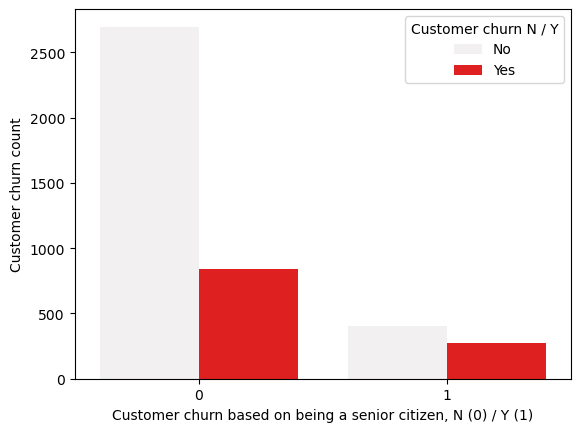

In [12]:
# COUNTPLOT 1 : customer churn and senior citizen

sc = sns.countplot(x = train.senior_citizen, hue = train.churn, color = 'red')

sc.set(ylabel = 'Customer churn count', xlabel = 'Customer churn based on being a senior citizen, N (0) / Y (1)')

plt.legend(loc = 'upper right', title = 'Customer churn N / Y')

**COUNTPLOT 1 : This countplot shows senior citizen churn rate. It appears that of the senior citizen customers (senior_citizen = 1) of Telco, though a smaller overall percentage of the customer base, the comparative rate of churn was higher than for non-senior citizens.**

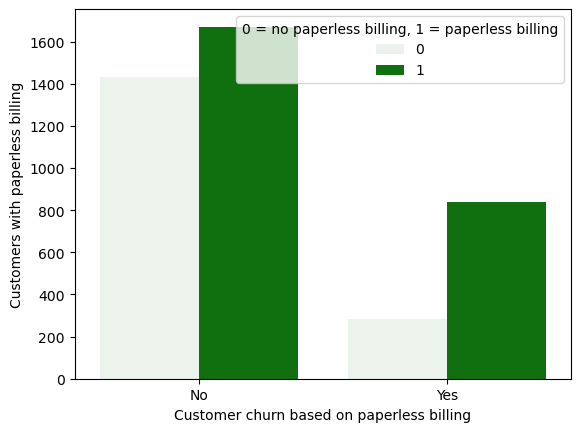

In [13]:
# COUNTPLOT 2 : churn vs paperless billing

paperless = sns.countplot(x = train.churn, hue = train.paperless_billing_Yes, color = 'green')

paperless.set(ylabel = 'Customers with paperless billing', xlabel = 'Customer churn based on paperless billing')

plt.legend(loc = 'upper right', title = '0 = no paperless billing, 1 = paperless billing')

# 0 = no paperless billing, 1 = paperless billing

**COUNTPLOT 2 : This countplot shows the relationship between customer use of paperless billing and customer churn counts. It appears that a significant amount of customers who have churn have also used paperless billing.**

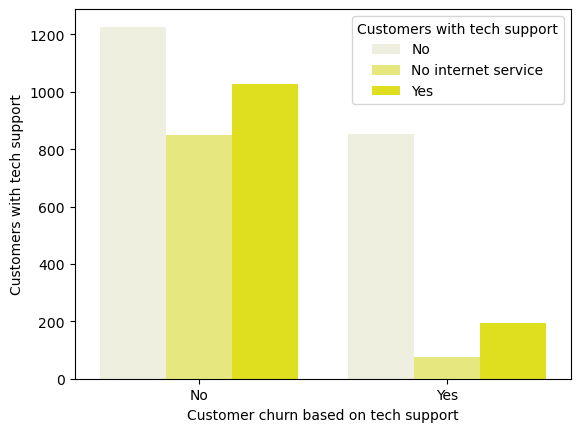

In [14]:
# COUNTPLOT 3 : tech_support and churn.

tech = sns.countplot(x = train.churn, hue = train.tech_support, color = 'yellow')

tech.set(ylabel = 'Customers with tech support', xlabel = 'Customer churn based on tech support')

plt.legend(loc = 'upper right', title = 'Customers with tech support')

**COUNTPLOT 3 : This countplot shows customer churn based on purchase of tech support. It appears that, for both customers who have churn and customers who have not churned, NOT purchasing tech support is the more popular option. Yet, of customers who have churned, the overwhelming majority did not purchase tech support. Of customers who have churned, a minimal amount had purchased tech support, which differs highly from the customers who have not churned.**

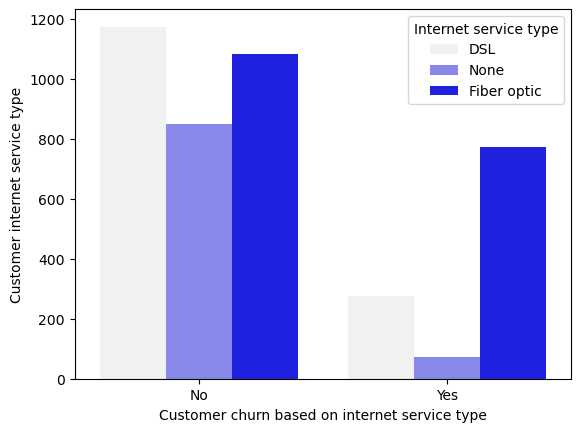

In [15]:
# COUNTPLOT 4 : The internet_service_type (ie, DSL, fiber optic, no internet service) AND churn rate.

ist = sns.countplot(x = train.churn, hue = train.internet_service_type, color = 'blue')

ist.set(ylabel = 'Customer internet service type', xlabel = 'Customer churn based on internet service type')

plt.legend(loc = 'upper right', title = 'Internet service type')

**COUNTPLOT 4 : This countplot shows the churn propensity for customers based on their internet service type. Churn or not, fiber optic internet is the more popular overall. For customers who have churned, an overwhelming amount were fiber optic subscribers.**

### OVERALL EXPLORATORY TAKEAWAYS :  
**After performing the Chi-Square test on three variables (senior citizen, paperless billing, tech support) compared with the target variable of customer churn, it was discovered that there was a correlation relationship between each of these three variables and customer churn rate.**


## STATISTICAL TESTS

For three of these four instances of examing the Telco data (senior citizen, paperless billing, tech support), it was decided to use ***Chi-square tests***, due to the individual variables' types : They were all independent, categorical variables.

### This will use the Chi-Square statistical test to explore Countplot 1 [customer age (senior citizens vs non-senior citizens) has an influence in churn rate]. 

- $H_{0}$ (Null Hypothesis): There is no relationship between being a senior citizen customer and customer churn. 

- $H_{a}$ (Alternative Hypothesis): There is a relationship between being a senior citizen customer and customer churn. 


In [16]:
## COUNTPLOT 1
# observed crosstab of senior_citizen (0, 1) and churn (no, yes)

# crosstab is the number of observations in each location of the table

observed_sc_ch = pd.crosstab(train.senior_citizen, train.churn)
observed_sc_ch

churn,No,Yes
senior_citizen,,
0,2697,844
1,407,277


In [17]:
## COUNTPLOT 1
## run the chi2_contingency on senior_citizen and churn based on the crosstab

chi2_sc_ch, p_sc_ch, degf_sc_ch, expected_sc_ch = stats.chi2_contingency(observed_sc_ch)

chi2_sc_ch, p_sc_ch, degf_sc_ch, expected_sc_ch

# expected = expected contingency table

(80.79361466512287,
 2.505662983276272e-19,
 1,
 array([[2601.48260355,  939.51739645],
        [ 502.51739645,  181.48260355]]))

In [18]:
## COUNTPLOT 1

α = 0.05

# print 'Observed Values' followed by a new line
print('Observed Values For Senior Citizens And Churn :\n')


# print the values from the 'observed' dataframe
print(observed_sc_ch.values)

print('')


# print -.-.-.-.- and then a new line, 'Expected Values', followed by another new line
print('-.-.-.-.-\n')
print('Expected Values For Senior Citizens And Churn :\n')


# print the expected values array
print(expected_sc_ch.astype(int))
# this turns the floats into integers, for readability

print('')

# print a new line
print('-.-.-.-.-\n')


# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2_sc_ch:.4f}') 


# print the p-value, formatted to a float with 4 digits {p:.4f}. 
print(f'p-value = {p_sc_ch:.4f}')

print('')

print('-.-.-.-.-\n')

print(f'Is the p-value < α ?', p_sc_ch < α)

# We know that the Expected values are not close to the Observed values due to the p-value being lower than α.

Observed Values For Senior Citizens And Churn :

[[2697  844]
 [ 407  277]]

-.-.-.-.-

Expected Values For Senior Citizens And Churn :

[[2601  939]
 [ 502  181]]

-.-.-.-.-

chi^2 = 80.7936
p-value = 0.0000

-.-.-.-.-

Is the p-value < α ? True


**Takeaways, COUNTPLOT 1 :**  
Though the Observed values for Countplot 1 appear to be relatively close to the Expected values in the contingency tables, the Chi-Square test indicates that there is some relationship between being a senior citizen and customer churn, due to the extremely low p-value. We, thus, reject the null hypothesis.

### This will use the Chi-Square statistical test to explore Countplot 2, whether use of paperless billing has an influence on churn rate.

- $H_{0}$ (Null Hypothesis): There is no relationship between use of paperless billing and customer churn. 

- $H_{a}$ (Alternative Hypothesis): There is a relationship between use of paperless billing and customer churn. 


In [19]:
## COUNTPLOT 2

# observed crosstab of paperless billing (0 = no, 1 = yes) and churn (no, yes)

# crosstab is the number of observations in each location of the table

observed_pb_ch = pd.crosstab(train.paperless_billing_Yes, train.churn)
observed_pb_ch

churn,No,Yes
paperless_billing_Yes,,
0,1433,283
1,1671,838


In [20]:
## COUNTPLOT 2

## run the chi2_contingency on tech_support and churn based on the crosstab

chi2_pb_ch, p_pb_ch, degf_pb_ch, expected_pb_ch = stats.chi2_contingency(observed_pb_ch)

chi2_pb_ch, p_pb_ch, degf_pb_ch, expected_pb_ch

(148.58446697144495,
 3.5348504574964642e-34,
 1,
 array([[1260.70153846,  455.29846154],
        [1843.29846154,  665.70153846]]))

In [21]:
## COUNTPLOT 2

α = 0.05

# print 'Observed Values' followed by a new line
print('Observed Values For Paperless Billing And Churn :\n')


# print the values from the 'observed' dataframe
print(observed_pb_ch.values)

print('')


# print -.-.-.-.- and then a new line, 'Expected Values', followed by another new line
print('-.-.-.-.-\n')
print('Expected Values For Paperless Billing And Churn :\n')


# print the expected values array
print(expected_pb_ch.astype(int))
# this turns the floats into integers, for readability

print('')

# print a new line
print('-.-.-.-.-\n')


# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2_pb_ch:.4f}') 


# print the p-value, formatted to a float with 4 digits {p:.4f}. 
print(f'p-value = {p_pb_ch:.4f}')

print('')

print('-.-.-.-.-\n')

print(f'Is the p-value < α ?', p_pb_ch < α)

# We know that the Expected values are not close to the Observed values due to the p-value being lower than α.

Observed Values For Paperless Billing And Churn :

[[1433  283]
 [1671  838]]

-.-.-.-.-

Expected Values For Paperless Billing And Churn :

[[1260  455]
 [1843  665]]

-.-.-.-.-

chi^2 = 148.5845
p-value = 0.0000

-.-.-.-.-

Is the p-value < α ? True


**Takeaways, COUNTPLOT 2 :**  
The Observed values for Countplot 2 appear very different from the Expected values in the contingency tables ; the Chi-Square test indicates that there is a relationship between customer use of paperless billing and customer churn, due to the extremely low p-value. We, thus, reject the null hypothesis.

### This will use the Chi-Square statistical test to explore Countplot 3, whether purchasing tech support has an influence on churn rate.

- $H_{0}$ (Null Hypothesis): There is no relationship between purchasing tech support and customer churn. 

- $H_{a}$ (Alternative Hypothesis): There is a relationship between purchasing tech support and customer churn. 


In [22]:
## COUNTPLOT 3

# observed crosstab of tech_support (no, no internet service, yes) and churn (no, yes)

# crosstab is the number of observations in each location of the table

observed_ts_ch = pd.crosstab(train.tech_support, train.churn)
observed_ts_ch

churn,No,Yes
tech_support,,
No,1227,852
No internet service,849,74
Yes,1028,195


In [23]:
## COUNTPLOT 3

## run the chi2_contingency on tech_support and churn based on the crosstab

chi2_ts_ch, p_ts_ch, degf_ts_ch, expected_ts_ch = stats.chi2_contingency(observed_ts_ch)

chi2_ts_ch, p_ts_ch, degf_ts_ch, expected_ts_ch


(455.3210599885817,
 1.3436559397518983e-99,
 2,
 array([[1527.38840237,  551.61159763],
        [ 678.10461538,  244.89538462],
        [ 898.50698225,  324.49301775]]))

In [24]:
## COUNTPLOT 3

α = 0.05

# print 'Observed Values' followed by a new line
print('Observed Values For Tech Support And Churn :\n')


# print the values from the 'observed' dataframe
print(observed_ts_ch.values)

print('')

# print -.-.-.-.- and then a new line, 'Expected Values', followed by another new line
print('-.-.-.-.-\n')
print('Expected Values For Tech Support And Churn :\n')


# print the expected values array
print(expected_ts_ch.astype(int))

print('')

print('-.-.-.-.-\n')


# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2_ts_ch:.4f}') 


# print the p-value, formatted to a float with 4 digits {p:.4f}. 
print(f'p-value = {p_ts_ch:.4f}')

print('')

print('-.-.-.-.-\n')

print(f'Is the p-value < α ?', p_ts_ch < α)

# We know that the Expected values are not close to the Observed values due to the p-value being lower than α.

Observed Values For Tech Support And Churn :

[[1227  852]
 [ 849   74]
 [1028  195]]

-.-.-.-.-

Expected Values For Tech Support And Churn :

[[1527  551]
 [ 678  244]
 [ 898  324]]

-.-.-.-.-

chi^2 = 455.3211
p-value = 0.0000

-.-.-.-.-

Is the p-value < α ? True


**Takeaways, COUNTPLOT 3 :**  
The Observed values for Countplot 3 appear very different from the Expected values in the contingency tables ; the Chi-Square test indicates that there is a relationship between customer purchase of tech support and customer churn, due to the extremely low p-value. We, thus, reject the null hypothesis.

## Takeaways, Statistical Summary :  
- After graphing the four hypotheses and using statistical testing on three of the hypotheses (senior citizen, paperless billing, tech support), it appears that there is a relationship between customer churn and the test variables, notably that tendancy towards churn is influence by being a senior citizen, or, separately, by use of paperless billing, or, separately, by the purchase of tech support.
  
  
- General takeaways are that the variables so far analysed using statistical testing (paperless billing, tech support, being a senior citizen) do have an influence on increased customer churn rates that lead rates.  
  
  
- Going forward, modelling will be done on all four variables, compared with the baseline of no-churn. The modelling seeks to determine potential actions of Telco customers, namely, how likely a customer is to churn, or, leave the company.**




## MODELLING OF VARIABLES

**Here, the four key variables (senior citizen, paperless billing, tech support, internet service type) will be modelled against the baseline of the target variable of customer churn.**

**To prepare for modelling, it is necessary to continue with the tidying of the Telco dataset, to allow for focus solely on the variables in questions. This comprises the creation of more dummies and the dropping of now-superfluous columns.**

In [25]:
#dropping any possible nulls

tidy_telco = tidy_telco.dropna()

In [26]:
# creating dummies in order to help machine learning and modelling

dummies = pd.get_dummies(tidy_telco[['tech_support', 'internet_service_type']], drop_first = True)

dummies

,tech_support_No internet service,tech_support_Yes,internet_service_type_Fiber optic,internet_service_type_None
0,0,1,0,0
1,0,0,0,0
2,0,0,1,0
3,0,0,1,0
4,0,1,1,0
...,...,...,...,...
7038,0,1,0,0
7039,0,0,1,0
7040,0,0,0,0
7041,0,1,0,0


In [27]:
# concatenating dummies to the tidy_telco dataframe

tidy_telco = pd.concat([tidy_telco, dummies], axis = 1)
tidy_telco.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,dependents_No,dependents_Yes,paperless_billing_No,paperless_billing_Yes,churn_No,churn_Yes,tech_support_No internet service,tech_support_Yes,internet_service_type_Fiber optic,internet_service_type_None
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,0,1,0,1,1,0,0,1,0,0
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,1,0,1,0,1,0,0,0,0,0
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,1,0,0,1,0,1,0,0,1,0
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,1,0,0,1,0,1,0,0,1,0
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,1,0,0,1,0,1,0,1,1,0


In [28]:
# dropping columns unnecessary for modelling (namely, objects and columns with dummies created for them)

drop_columns = ['customer_id', 'gender', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines',
               'online_security', 'online_backup', 'device_protection', 'streaming_tv','streaming_movies', 
                'total_charges', 'gender_Female', 'gender_Male', 'partner_No', 'partner_Yes', 'dependents_No',
                'dependents_Yes', 'payment_type', 'contract_type', 'churn', 'paperless_billing', 'tech_support', 
               'internet_service_type', 'monthly_charges']

In [29]:
# dropping columns for machine learning purposes

tidy_telco.drop(columns = drop_columns, inplace = True)

tidy_telco.head()

,senior_citizen,paperless_billing_No,paperless_billing_Yes,churn_No,churn_Yes,tech_support_No internet service,tech_support_Yes,internet_service_type_Fiber optic,internet_service_type_None
0,0,0,1,1,0,0,1,0,0
1,0,1,0,1,0,0,0,0,0
2,0,0,1,0,1,0,0,1,0
3,1,0,1,0,1,0,0,1,0
4,1,0,1,0,1,0,1,1,0


In [30]:
# checking values in tidy_telco

tidy_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   senior_citizen                     7043 non-null   int64
 1   paperless_billing_No               7043 non-null   uint8
 2   paperless_billing_Yes              7043 non-null   uint8
 3   churn_No                           7043 non-null   uint8
 4   churn_Yes                          7043 non-null   uint8
 5   tech_support_No internet service   7043 non-null   uint8
 6   tech_support_Yes                   7043 non-null   uint8
 7   internet_service_type_Fiber optic  7043 non-null   uint8
 8   internet_service_type_None         7043 non-null   uint8
dtypes: int64(1), uint8(8)
memory usage: 110.2 KB


In [31]:
# splitting into train-validate-test in preparation for modelling


train_m, validate_m, test_m = my_train_test_split(tidy_telco, target = 'churn_No')

train_m.shape, validate_m.shape, test_m.shape

((4225, 9), (1409, 9), (1409, 9))

In [32]:
# # baseline for churn is no-churn (ie, ['churn_No'] == '1').

train_m[train_m.churn_No == 1]

# churn_Yes = 0. // 0 = False, thus, if churn_Yes is False, then the customer has not churned
# if churn_Yes = 1, then churn_Yes is true, and the customer has churned

,senior_citizen,paperless_billing_No,paperless_billing_Yes,churn_No,churn_Yes,tech_support_No internet service,tech_support_Yes,internet_service_type_Fiber optic,internet_service_type_None
3441,0,0,1,1,0,0,0,1,0
1266,0,0,1,1,0,0,0,1,0
5086,0,1,0,1,0,0,1,0,0
5279,1,1,0,1,0,0,0,0,0
134,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
2791,0,0,1,1,0,1,0,0,1
6776,0,1,0,1,0,1,0,0,1
141,0,1,0,1,0,0,0,0,0
5053,1,1,0,1,0,0,0,0,0


In [33]:
baseline = (train_m.churn_No == 1).mean()
baseline

# how many customers did not churn
# my baseline is about 73.46pc

0.7346745562130178

**This baseline of about 73.46pc indicates the likelihood that a given customer will remain a Telco customer.   
  The inverse, or about 26.53pc, is the likelihood that a given customer would leave Telco.**

In [34]:
# comparing the 'churn' and 'churn_No' columns

train_m.churn_No.value_counts()

# 1 = True (ie, no-churned).

1    3104
0    1121
Name: churn_No, dtype: int64

In [35]:
## split train, val, test from above into X_train, X_val, X_test and y-train, etc
# y_train is only our target
# X_ is everything except for 'churn_Yes' and 'churn_No'


X_train = train_m.drop(columns = ['churn_Yes', 'churn_No'])
y_train = train_m['churn_No']

X_val = validate_m.drop(columns = ['churn_Yes', 'churn_No'])
y_val = validate_m['churn_No']

X_test = test_m.drop(columns = ['churn_Yes', 'churn_No'])
y_test = test_m['churn_No']

In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 3441 to 6996
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   senior_citizen                     4225 non-null   int64
 1   paperless_billing_No               4225 non-null   uint8
 2   paperless_billing_Yes              4225 non-null   uint8
 3   tech_support_No internet service   4225 non-null   uint8
 4   tech_support_Yes                   4225 non-null   uint8
 5   internet_service_type_Fiber optic  4225 non-null   uint8
 6   internet_service_type_None         4225 non-null   uint8
dtypes: int64(1), uint8(6)
memory usage: 90.8 KB


In [37]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 2742 to 3864
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   senior_citizen                     1409 non-null   int64
 1   paperless_billing_No               1409 non-null   uint8
 2   paperless_billing_Yes              1409 non-null   uint8
 3   tech_support_No internet service   1409 non-null   uint8
 4   tech_support_Yes                   1409 non-null   uint8
 5   internet_service_type_Fiber optic  1409 non-null   uint8
 6   internet_service_type_None         1409 non-null   uint8
dtypes: int64(1), uint8(6)
memory usage: 30.3 KB


In [38]:
X_train.head()

,senior_citizen,paperless_billing_No,paperless_billing_Yes,tech_support_No internet service,tech_support_Yes,internet_service_type_Fiber optic,internet_service_type_None
3441,0,0,1,0,0,1,0
289,0,1,0,1,0,0,1
1266,0,0,1,0,0,1,0
275,1,0,1,0,0,1,0
5086,0,1,0,0,1,0,0


### Modelling On The Decision Tree : Depth Of 3

In [39]:
# initialise the Decision Tree Classifier = clf

seed = 23

clf3 = DecisionTreeClassifier(max_depth = 3, random_state = seed)

In [40]:
# fitting the model : 
    # it must know the features and the labels, in order to associate them with one another.
    
# with this step, the model has been trained.

clf3 = clf3.fit(X_train, y_train)
clf3

DecisionTreeClassifier(max_depth=3, random_state=23)

In [41]:
# Examining accuracy of Decision Tree Classifier model :
# prediction on the X_train set against the y_train reality.


clf3.score(X_train, y_train)

# the X_train data is compared against y_train : 75.03pc accuracy

0.743905325443787

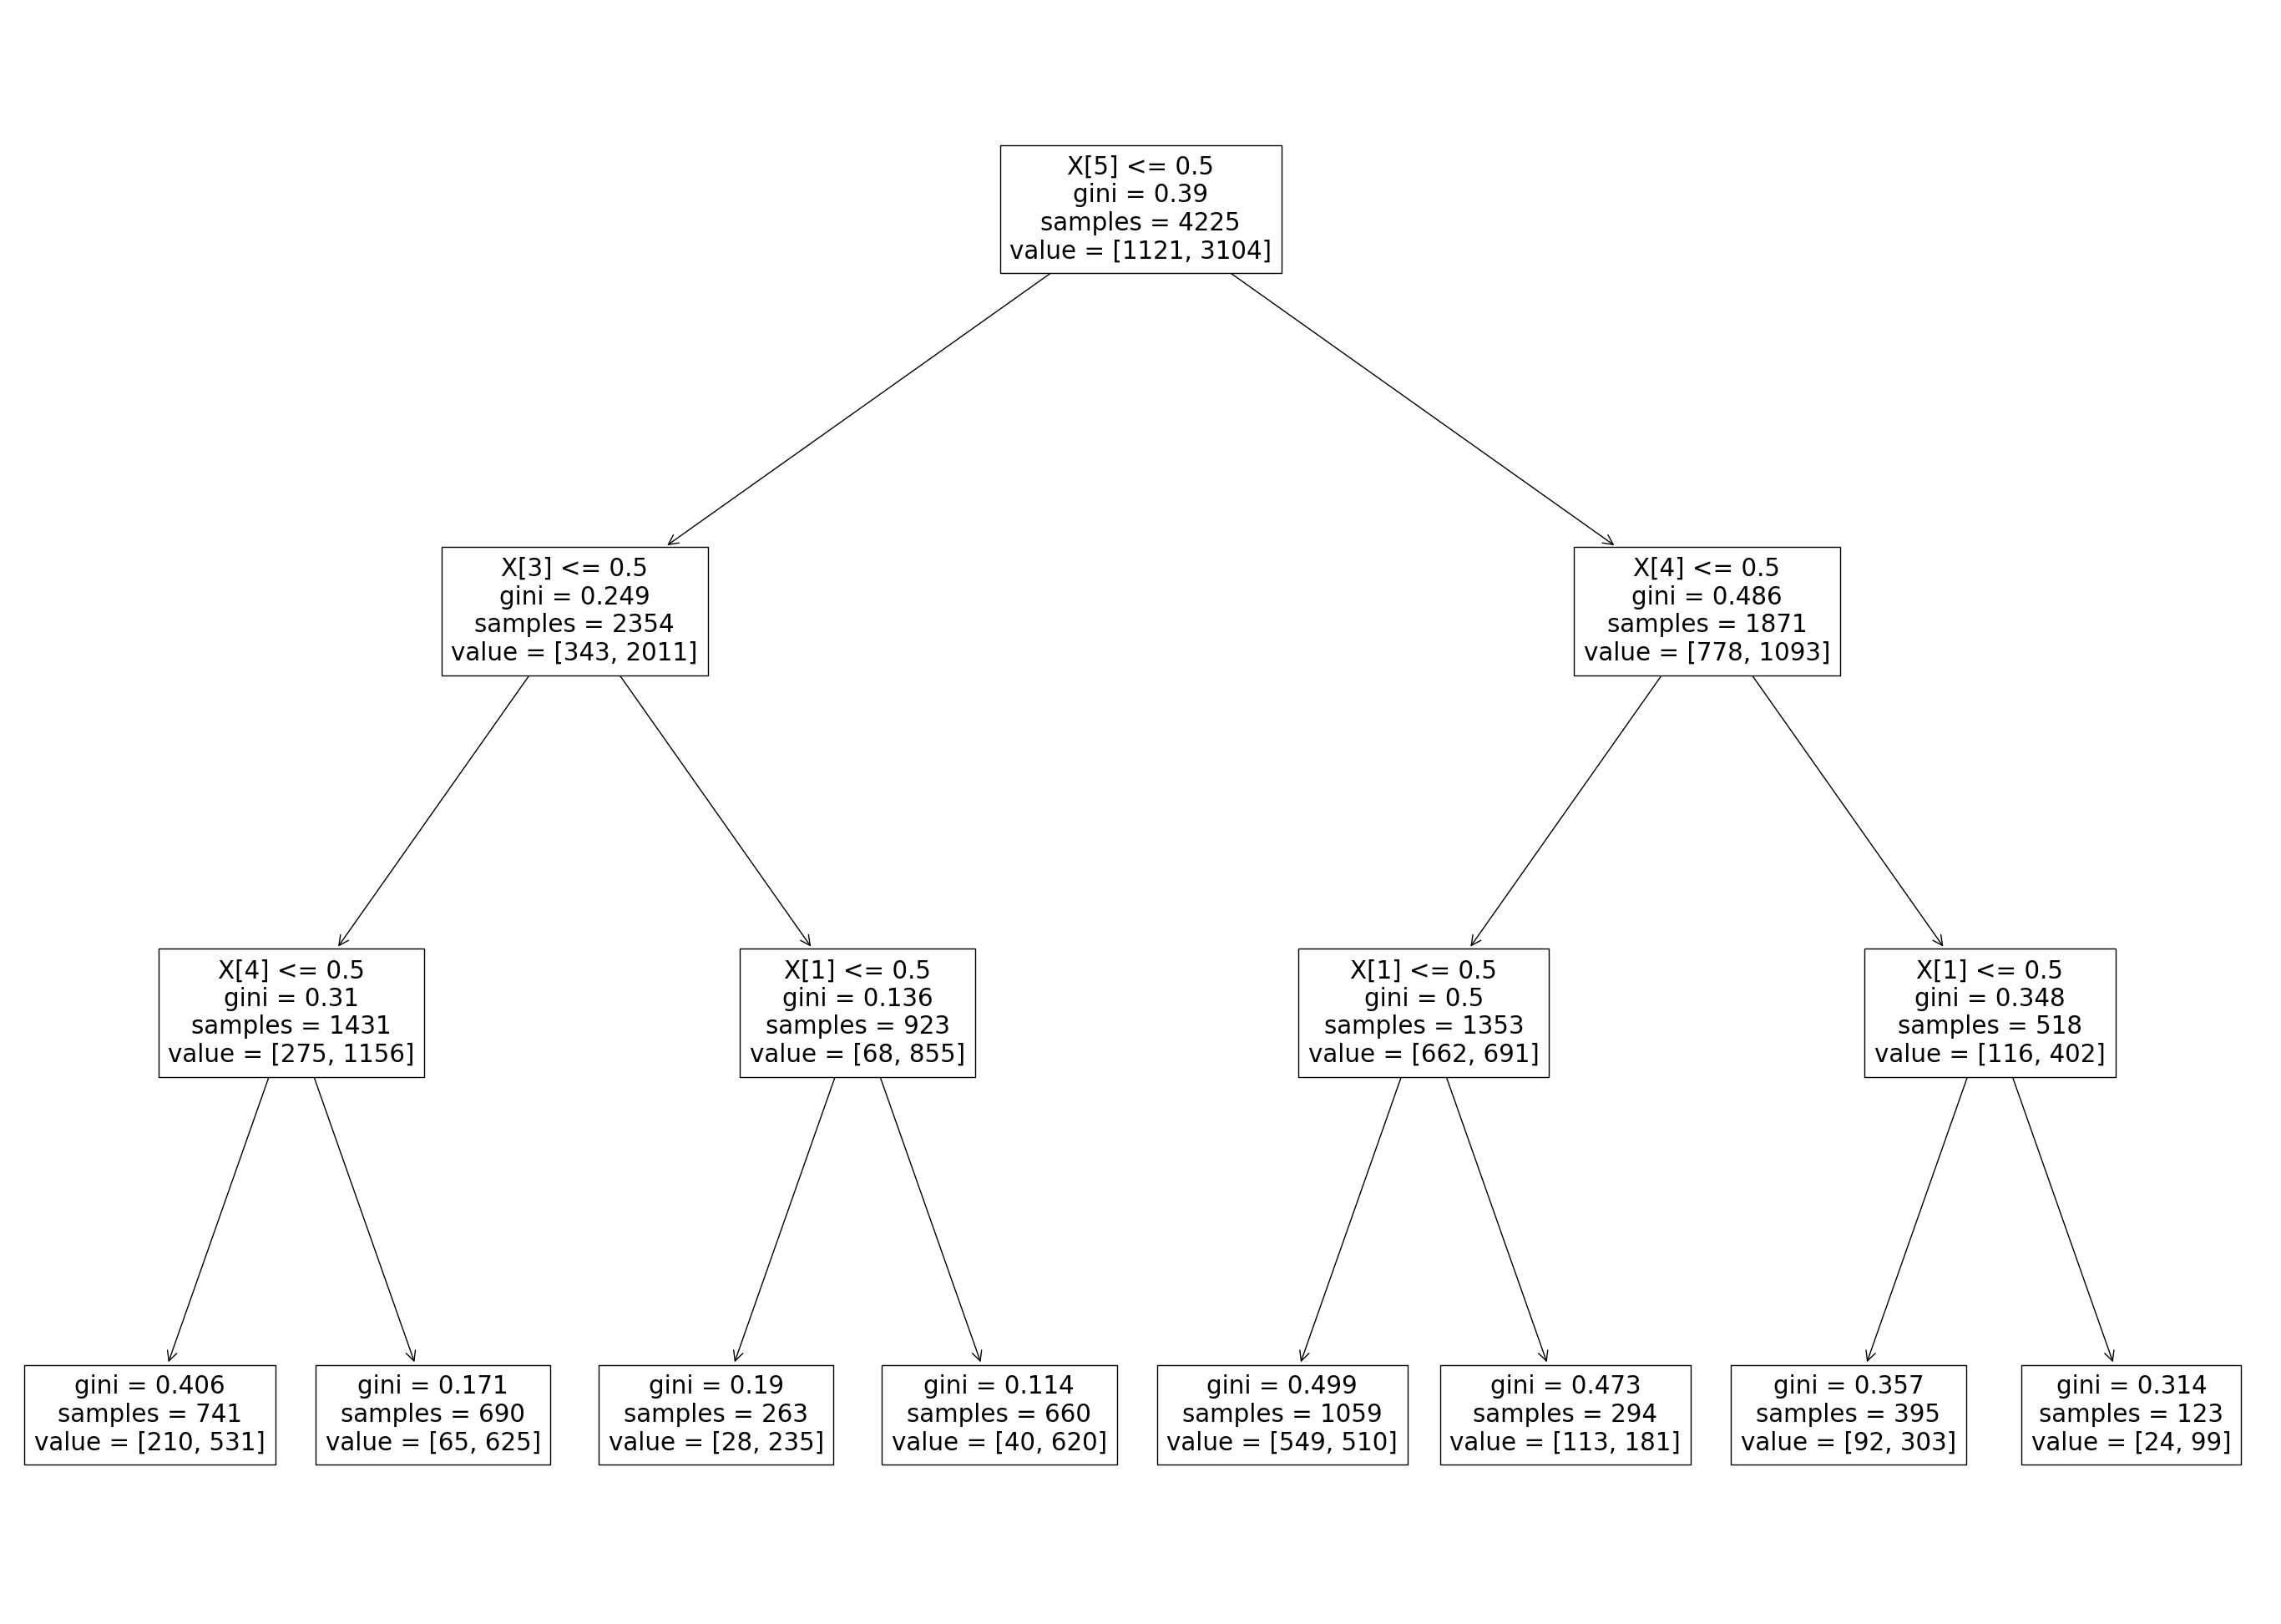

In [42]:
# plotting the Decision Tree 

plt.figure(figsize = (35, 25))

plot_tree(clf3, rounded = False)

plt.show()


# max depth of 3 = three layers of decisions / splits being made in data

In [43]:
# predictions for churn are on the X_train ; true values are on y_train

y_train_predictions3 = clf3.predict(X_train)

y_train_predictions3[0:20]



array([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
      dtype=uint8)

In [44]:
# estimating the probability of churn for each customer based on X_train

y_predict_prob3 = clf3.predict_proba(X_train)
y_predict_prob3[0:20]

# each row adds up to 1 (F prob / T prob)

array([[0.5184136 , 0.4815864 ],
       [0.06060606, 0.93939394],
       [0.5184136 , 0.4815864 ],
       [0.5184136 , 0.4815864 ],
       [0.0942029 , 0.9057971 ],
       [0.28340081, 0.71659919],
       [0.38435374, 0.61564626],
       [0.28340081, 0.71659919],
       [0.0942029 , 0.9057971 ],
       [0.5184136 , 0.4815864 ],
       [0.0942029 , 0.9057971 ],
       [0.0942029 , 0.9057971 ],
       [0.5184136 , 0.4815864 ],
       [0.06060606, 0.93939394],
       [0.28340081, 0.71659919],
       [0.06060606, 0.93939394],
       [0.0942029 , 0.9057971 ],
       [0.0942029 , 0.9057971 ],
       [0.5184136 , 0.4815864 ],
       [0.28340081, 0.71659919]])

In [45]:
## print the classification report :

print(f'Classification Report For Training Dataset \n  \n {classification_report(y_train, y_train_predictions3)}')

# Accuracy of 75pc

Classification Report For Training Dataset 
  
               precision    recall  f1-score   support

           0       0.52      0.49      0.50      1121
           1       0.82      0.84      0.83      3104

    accuracy                           0.74      4225
   macro avg       0.67      0.66      0.67      4225
weighted avg       0.74      0.74      0.74      4225



In [46]:
# Turning the training accuracy score into a useable variable 

train_accuracy3 = clf3.score(X_train, y_train)
train_accuracy3

0.743905325443787

In [47]:
# printing statment that makes sense to the general public :

print(f'The accuracy of the Decision Tree Classifier on the training dataset is{train_accuracy3: .4f}.  \n'
      f'The baseline accuracy for customer churn is{baseline: .4f}, meaning that about\n' 
      '     73.47pc of customers will NOT churn.')

The accuracy of the Decision Tree Classifier on the training dataset is 0.7439.  
The baseline accuracy for customer churn is 0.7347, meaning that about
     73.47pc of customers will NOT churn.


In [48]:
# confusion matrix : A table of prediction vs actual

confusion_matrix(y_train, y_train_predictions3)

array([[ 549,  572],
       [ 510, 2594]])

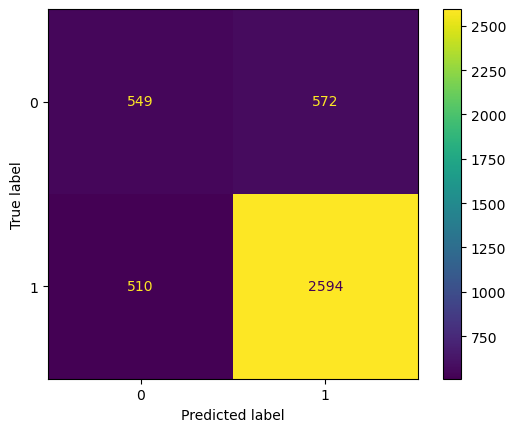

In [49]:
## plotting the confusion matrix of clf

plot_confusion_matrix(clf3, X_train, y_train)

In [50]:
# code necessary for the confusion matrix function to function

y_preds3 = pd.DataFrame({
    'y_act': y_train,
    'baseline': 1,
    'model_1': clf3.predict(X_train)
})


In [51]:
# assigning confusion matrix values to appropriate variables

TN3, FP3, FN3, TP3 = confusion_matrix(y_preds3.y_act, y_preds3.model_1).ravel()

print(f'TN = {TN3}, FP = {FP3}, FN = {FN3}, TP = {TP3}')

TN = 549, FP = 572, FN = 510, TP = 2594


**The validation step for a depth of 3, which follows, of the Decision Tree Classifier authenticates the accuracy of the evaluation of the training dataset.**

In [52]:
#VALIDATION STEP

y_val_predictions3 = clf3.predict(X_val)
y_val_predictions3[0:20]

# predicted on X_Val, true values are on y_val

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1],
      dtype=uint8)

In [53]:
# estimating the probability of churn for each customer based on X_validate dataset

y_val_pred_prob3 = clf3.predict_proba(X_val)
y_val_pred_prob3[0:20]

# each row adds up to 1 (F prob / T prob)

array([[0.06060606, 0.93939394],
       [0.5184136 , 0.4815864 ],
       [0.5184136 , 0.4815864 ],
       [0.5184136 , 0.4815864 ],
       [0.5184136 , 0.4815864 ],
       [0.0942029 , 0.9057971 ],
       [0.5184136 , 0.4815864 ],
       [0.06060606, 0.93939394],
       [0.28340081, 0.71659919],
       [0.06060606, 0.93939394],
       [0.23291139, 0.76708861],
       [0.38435374, 0.61564626],
       [0.5184136 , 0.4815864 ],
       [0.28340081, 0.71659919],
       [0.06060606, 0.93939394],
       [0.5184136 , 0.4815864 ],
       [0.5184136 , 0.4815864 ],
       [0.5184136 , 0.4815864 ],
       [0.38435374, 0.61564626],
       [0.23291139, 0.76708861]])

In [54]:
## print the classification report for a depth of 3 :

print(f'Classification Report For Training Dataset, Depth Of 3\n  \n {classification_report(y_val, y_val_predictions3)}')

# Accuracy of 75pc

Classification Report For Training Dataset, Depth Of 3
  
               precision    recall  f1-score   support

           0       0.54      0.50      0.52       374
           1       0.82      0.85      0.83      1035

    accuracy                           0.75      1409
   macro avg       0.68      0.67      0.68      1409
weighted avg       0.75      0.75      0.75      1409



In [55]:
# Turning the training accuracy score into a useable variable 

val_accuracy3 = clf3.score(X_val, y_val)
val_accuracy3

0.7544357700496807

In [56]:
# printing statment that makes sense to the general public :

print(f'The accuracy of the Decision Tree Classifier on the validation dataset is{val_accuracy3: .4f}.  \n'
      f'The baseline accuracy for customer churn is{baseline: .4f}.')

The accuracy of the Decision Tree Classifier on the validation dataset is 0.7544.  
The baseline accuracy for customer churn is 0.7347.


**Takeaway, Depth Of 3 :**   
The accuracy of the training dataset and the validation dataset was 75.05pc and 75.23pc, respectively.  
Both of these results are higher than the baseline accuracy for customer churn, with 73.47pc who would not churn.

### Modelling On The Decision Tree : Depth Of 7

In [57]:
# initialise the Decision Tree Classifier = clf7
# depth of 7

seed = 23

clf7 = DecisionTreeClassifier(max_depth = 7, random_state = seed)

In [58]:
# fitting the model : 
    # it must know the features and the labels, in order to associate them with one another.
    
# depth of 7

clf7 = clf7.fit(X_train, y_train)
clf7

DecisionTreeClassifier(max_depth=7, random_state=23)

In [59]:
# Examining accuracy of Decision Tree Classifier model :
# prediction on the X_train set against the y_train reality.
# depth of 7

clf7.score(X_train, y_train)

# the X_train data is compared against y_train : 77.21pc accuracy

0.743905325443787

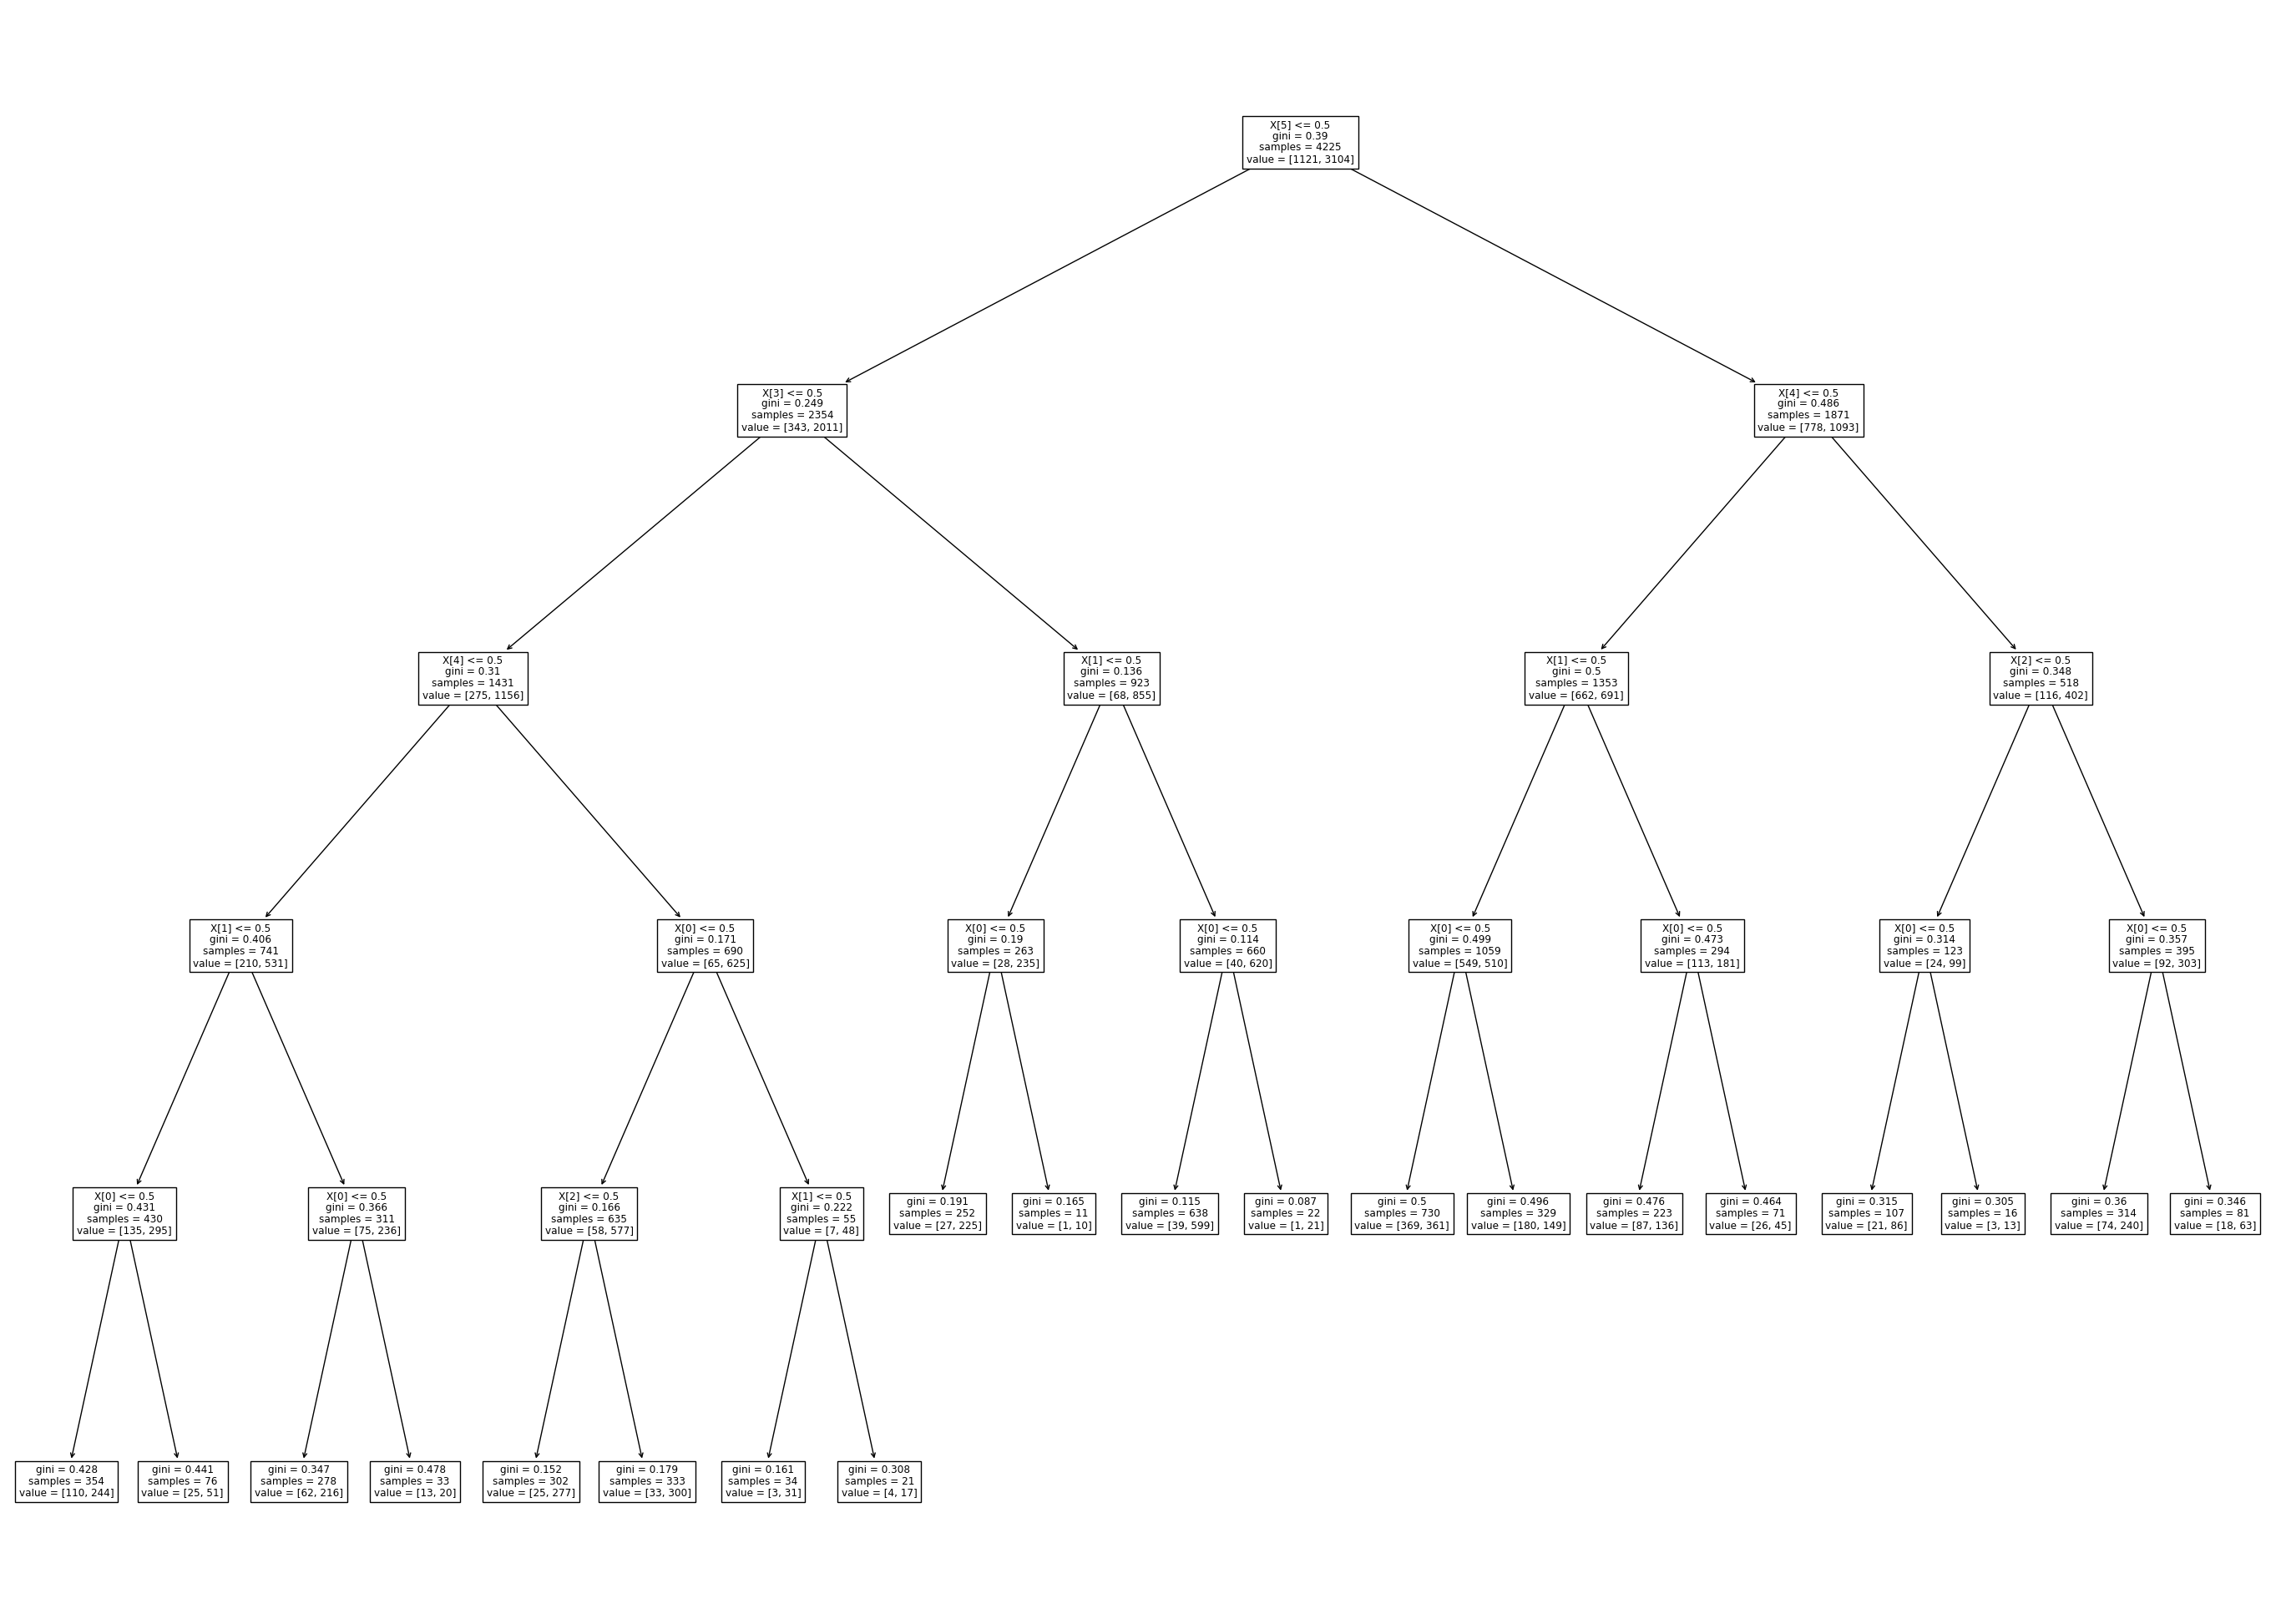

In [60]:
# plotting the Decision Tree 
# depth of 7

plt.figure(figsize = (35, 25))

plot_tree(clf7, rounded = False)

plt.show()


# max depth of 7 = three layers of decisions / splits being made in data

In [61]:
# predictions for churn are on the X_train ; true values are on y_train
# depth of 7

y_train_predictions7 = clf7.predict(X_train)

y_train_predictions7[0:20]



array([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
      dtype=uint8)

In [62]:
# estimating the probability of churn for each customer based on X_train
# depth of 7

y_predict_prob7 = clf7.predict_proba(X_train)
y_predict_prob7[0:20]

# each row adds up to 1 (F prob / T prob)

array([[0.50547945, 0.49452055],
       [0.06112853, 0.93887147],
       [0.50547945, 0.49452055],
       [0.54711246, 0.45288754],
       [0.08278146, 0.91721854],
       [0.39393939, 0.60606061],
       [0.39013453, 0.60986547],
       [0.22302158, 0.77697842],
       [0.0990991 , 0.9009009 ],
       [0.50547945, 0.49452055],
       [0.0990991 , 0.9009009 ],
       [0.08278146, 0.91721854],
       [0.50547945, 0.49452055],
       [0.06112853, 0.93887147],
       [0.22302158, 0.77697842],
       [0.06112853, 0.93887147],
       [0.08278146, 0.91721854],
       [0.08278146, 0.91721854],
       [0.50547945, 0.49452055],
       [0.31073446, 0.68926554]])

In [63]:
## print the classification report :

print(f'Classification Report For Training Dataset \n  \n {classification_report(y_train, y_train_predictions7)}')

# Accuracy of 77pc

Classification Report For Training Dataset 
  
               precision    recall  f1-score   support

           0       0.52      0.49      0.50      1121
           1       0.82      0.84      0.83      3104

    accuracy                           0.74      4225
   macro avg       0.67      0.66      0.67      4225
weighted avg       0.74      0.74      0.74      4225



In [64]:
# Turning the training accuracy score into a useable variable 

train_accuracy7 = clf7.score(X_train, y_train)
train_accuracy7

0.743905325443787

In [65]:
# printing statment that makes sense to the general public
# depth of 7

print(f'The accuracy of the Decision Tree Classifier on the training dataset at a depth of 7 is{train_accuracy7: .4f}.  \n'
      f'The baseline accuracy for customer churn is{baseline: .4f}, meaning that about 73.47pc of customers will NOT churn.')

The accuracy of the Decision Tree Classifier on the training dataset at a depth of 7 is 0.7439.  
The baseline accuracy for customer churn is 0.7347, meaning that about 73.47pc of customers will NOT churn.


In [66]:
# confusion matrix : A table of prediction vs actual
# depth of 7

confusion_matrix(y_train, y_train_predictions7)

array([[ 549,  572],
       [ 510, 2594]])

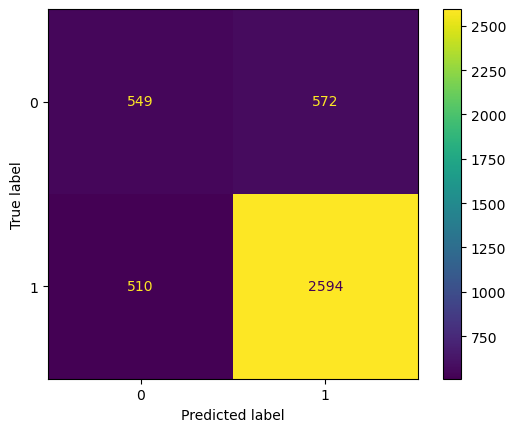

In [67]:
## plotting the confusion matrix of clf
# depth of 7

plot_confusion_matrix(clf7, X_train, y_train)

In [68]:
# code necessary for the confusion matrix function to function
# depth of 7

y_preds7 = pd.DataFrame({
    'y_act': y_train,
    'baseline': 1,
    'model_2': clf7.predict(X_train)
})


In [69]:
# assigning confusion matrix values to appropriate variables
# depth of 7

TN7, FP7, FN7, TP7 = confusion_matrix(y_preds7.y_act, y_preds7.model_2).ravel()

print(f'TN = {TN7}, FP = {FP7}, FN = {FN7}, TP = {TP7}')

TN = 549, FP = 572, FN = 510, TP = 2594


**The validation step for a depth of 7, which folllows, of the Decision Tree Classifier authenticates the accuracy of the evaluation of the training dataset.**

In [70]:
#VALIDATION STEP
# depth of 7

y_val_predictions7 = clf7.predict(X_val)
y_val_predictions7[0:20]

# predicted on X_Val, true values are on y_val

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1],
      dtype=uint8)

In [71]:
# estimating the probability of churn for each customer based on X_validate dataset
# depth of 7

y_val_pred_prob7 = clf7.predict_proba(X_val)
y_val_pred_prob7[0:20]

# each row adds up to 1 (F prob / T prob)

array([[0.06112853, 0.93887147],
       [0.50547945, 0.49452055],
       [0.50547945, 0.49452055],
       [0.54711246, 0.45288754],
       [0.50547945, 0.49452055],
       [0.08278146, 0.91721854],
       [0.54711246, 0.45288754],
       [0.06112853, 0.93887147],
       [0.31073446, 0.68926554],
       [0.06112853, 0.93887147],
       [0.23566879, 0.76433121],
       [0.39013453, 0.60986547],
       [0.50547945, 0.49452055],
       [0.22302158, 0.77697842],
       [0.06112853, 0.93887147],
       [0.50547945, 0.49452055],
       [0.50547945, 0.49452055],
       [0.50547945, 0.49452055],
       [0.39013453, 0.60986547],
       [0.23566879, 0.76433121]])

In [72]:
## print the classification report for a depth of 7 :

print(f'Classification Report For Training Dataset, Depth Of 3\n  \n {classification_report(y_val, y_val_predictions7)}')

# Accuracy of 76pc

Classification Report For Training Dataset, Depth Of 3
  
               precision    recall  f1-score   support

           0       0.54      0.50      0.52       374
           1       0.82      0.85      0.83      1035

    accuracy                           0.75      1409
   macro avg       0.68      0.67      0.68      1409
weighted avg       0.75      0.75      0.75      1409



In [73]:
# Turning the training accuracy score into a useable variable 
# depth of 7

val_accuracy7 = clf7.score(X_val, y_val)
val_accuracy7

0.7544357700496807

In [74]:
# printing statment that makes sense to the general public
# depth of 7

print(f'The accuracy of the Decision Tree Classifier on the validation dataset for a depth of 7 is{val_accuracy7: .4f}.  \n'
      f'The baseline accuracy for customer churn is{baseline: .4f}.')

The accuracy of the Decision Tree Classifier on the validation dataset for a depth of 7 is 0.7544.  
The baseline accuracy for customer churn is 0.7347.


**Takeaway, Depth Of 7 :**  
The training and validation datasets for a depth of 7 have an overall higher accuracy than the Decision Tree model with a depth of 3. Regardless, both models have a higher accuracy than the baseline.

**Decision Tree Overall Takeaways :**  
- The depth of 7 in the Decision Tree Classifier model returns an accuracy of 77.21pc for the training dataset, and 75.73pc for the validation dataset.  
- These accuracy results are slightly higher than for a depth of 3, yet the model with a depth of 7 is not overfit. Furthermore, the percentage accuracy gap between the training dataset and the validation dataset for a depth of 7 is smaller than for a depth of 3.  
- Based on these results, it would be preferable to use the Decision Tree Classifier model with a depth of 7.

### Modelling Based On K-Nearest Neighbor : 15 Neighbours

In [75]:
# creating the KNN variable for modelling
# looking to 15 neighbours

knn15 = KNeighborsClassifier(n_neighbors = 15)

In [76]:
# training the KNN model

knn15.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=15)

In [77]:
# scoring the model to determine how accurate the KNN model is. 

train_knn15_score = knn15.score(X_train, y_train)

# we're predicting on the features (X_train, the first variable), and
# comparing to the actual labels (the 2nd variable, y_train)

print(f'The accuracy of the training dataset using the KNN model with 15 neighbours is{train_knn15_score: .4f}.')

The accuracy of the training dataset using the KNN model with 15 neighbours is 0.7366.


In [78]:
# examining the accuracy of the validation dataset 

val_knn15_score = knn15.score(X_val, y_val)

print(f'The accuracy of the validation dataset using the KNN model with 15 neighbours is{val_knn15_score: .4f}.')

The accuracy of the validation dataset using the KNN model with 15 neighbours is 0.7331.


**Takeaway :**  
With 15 neighbours, the training dataset accuracy is 77.16pc, but for the validation dataset, the accuracy is 74.45pc, which is an acceptable gap between the two datasets.

### Modelling based on K-Nearest Neighbor : 11 Neighbours

In [79]:
# creating the KNN variable for modelling with 11 neighbours

knn11 = KNeighborsClassifier(n_neighbors = 11)

In [80]:
# training the KNN model on 11 neighbours

knn11.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [81]:
# scoring the model to determine how accurate the KNN model is. 

train_knn11_score = knn11.score(X_train, y_train)

# we're predicting on the features (X_train, the first variable), and
# comparing to the actual labels (the 2nd variable, y_train)

print(f'The accuracy of the training dataset using the KNN model with 11 neighbours is{train_knn11_score: .4f}.')

The accuracy of the training dataset using the KNN model with 11 neighbours is 0.7001.


In [82]:
# examining the accuracy of the validation dataset 

val_knn11_score = knn11.score(X_val, y_val)

print(f'The accuracy of the validation dataset using the KNN model with 11 neighbours is{val_knn11_score: .4f}.')

The accuracy of the validation dataset using the KNN model with 11 neighbours is 0.6863.


**Takeaway :**  
With 11 neighbours, the training dataset accuracy is 77.70pc, but for the validation dataset, it's only 73.03pc, which is a gap slightly larger than desireable for analysis of the dataset.

**KNN Overall Takeaways :**  
- When comparing the KNN model with 11 neighbours to the KNN model with 15 neighbours, the training dataset accuracy for 11 neighbours is quite close to the model with 15 neighbours (0.54pc difference). 
- The validation dataset accuracy for 11 KNN neighbours is more 1.42pc lower than the KNN model with 15 neighbours. 
- Based on these results, the KNN model with 15 neigbhours would be preferable.